## Import & Data Load

In [98]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
import statsmodels.api as sm
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

train = pd.read_csv('/content/drive/MyDrive/hd/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('/content/drive/MyDrive/hd/test.csv').drop(columns=['SAMPLE_ID'])
#train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
#test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [99]:
train.shape

(367441, 26)

In [100]:
train.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
0,CN,EKP8,Bulk,30.736578,2020-10-15 4:03,Z517571,30.0,28,73100,20.0,...,3.77,15.9,2.730798,12,42.01,43.16,40.96,1407.668330,0.001660,3.048333
1,CN,EUC8,Container,63.220425,2019-09-17 2:55,U467618,30.0,15,37900,20.0,...,-6.72,24.5,4.289058,10,67.53,64.55,59.34,2089.046774,0.001614,17.138611
2,CN,NGG6,Container,90.427421,2019-02-23 6:43,V378315,50.0,7,115000,20.0,...,0.00,9.4,0.000000,14,65.30,66.39,56.94,603.193047,0.001743,98.827500
3,JP,TMR7,Cargo,0.000000,2020-09-18 22:06,B726632,10.0,33,1490,10.0,...,-7.31,22.1,4.693735,7,43.02,43.15,41.11,1169.853455,0.000069,0.000000
4,RU,NNC2,Container,8.813725,2022-08-13 12:57,D215135,30.0,10,27600,10.0,...,2.31,22.8,2.345875,14,90.45,93.65,88.11,1107.944894,0.000197,96.030556


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367441 entries, 0 to 367440
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              367441 non-null  object 
 1   ARI_PO              367441 non-null  object 
 2   SHIP_TYPE_CATEGORY  367441 non-null  object 
 3   DIST                367441 non-null  float64
 4   ATA                 367441 non-null  object 
 5   ID                  367441 non-null  object 
 6   BREADTH             367440 non-null  float64
 7   BUILT               367441 non-null  int64  
 8   DEADWEIGHT          367441 non-null  int64  
 9   DEPTH               367440 non-null  float64
 10  DRAUGHT             367440 non-null  float64
 11  GT                  367441 non-null  int64  
 12  LENGTH              367440 non-null  float64
 13  SHIPMANAGER         367441 non-null  object 
 14  FLAG                367441 non-null  object 
 15  U_WIND              213955 non-nul

In [ ]:
train.isnull().sum()

ARI_CO                     0
ARI_PO                     0
SHIP_TYPE_CATEGORY         0
DIST                       0
ATA                        0
ID                         0
BREADTH                    1
BUILT                      0
DEADWEIGHT                 0
DEPTH                      1
DRAUGHT                    1
GT                         0
LENGTH                     1
SHIPMANAGER                0
FLAG                       0
U_WIND                153486
V_WIND                153486
AIR_TEMPERATURE       154365
BN                    153486
ATA_LT                     0
DUBAI                      0
BRENT                      0
WTI                        0
BDI_ADJ                    0
PORT_SIZE                  0
CI_HOUR                    0
dtype: int64

## Data Pre-processing

In [101]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

for df in [train, test]:
  df.sort_values(by=['ATA'],inplace=True)
  df.set_index(df['ATA'],inplace=True)


# datetime을 여러 파생 변수로 변환

for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday



# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

In [ ]:
# test 결측치 처리 or train결측치 삭제
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 367441 entries, 2014-09-01 00:05:00 to 2023-02-28 14:55:00
Data columns (total 31 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              367441 non-null  object 
 1   ARI_PO              367441 non-null  object 
 2   SHIP_TYPE_CATEGORY  367441 non-null  object 
 3   DIST                367441 non-null  float64
 4   ID                  367441 non-null  object 
 5   BREADTH             367441 non-null  float64
 6   BUILT               367441 non-null  int64  
 7   DEADWEIGHT          367441 non-null  int64  
 8   DEPTH               367441 non-null  float64
 9   DRAUGHT             367441 non-null  float64
 10  GT                  367441 non-null  int64  
 11  LENGTH              367441 non-null  float64
 12  SHIPMANAGER         367441 non-null  object 
 13  FLAG                367441 non-null  object 
 14  U_WIND              367441 non-null  float64
 15  

In [ ]:
train.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BUILT,DEPTH,SHIPMANAGER,FLAG,U_WIND,...,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday
ATA,,,,,,,,,,,,,,,,,,,,,
2018-11-11 08:59:00,RU,VXM8,Bulk,0.964323,F737633,8,20,OXWX22,"Hong Kong, China",0.00,...,52.64,565.203930,0.000145,2125.051667,2018,11,11,8,59,6
2018-11-12 10:13:00,JP,ZAG4,Container,103.280265,F447848,8,10,IMEE46,Japan,0.00,...,52.72,556.864856,0.000356,2102.433333,2018,11,12,10,13,0
2018-11-13 05:09:00,SG,GIW5,Container,90.737773,U467618,15,20,CUFV52,Singapore,0.00,...,54.23,669.649170,0.002615,1877.019722,2018,11,13,5,9,1
2018-11-15 01:43:00,CN,EUC8,Container,58.497944,I231688,10,30,PSPJ35,"Hong Kong, China",1.51,...,52.41,551.305473,0.001614,2111.980556,2018,11,15,1,43,3
2018-11-16 05:25:00,SG,GIW5,Container,11.310094,D826246,18,20,GLHT86,Panama,0.00,...,53.66,582.808643,0.002615,1944.873611,2018,11,16,5,25,4


array([[<Axes: title={'center': 'DIST'}>,
        <Axes: title={'center': 'BUILT'}>,
        <Axes: title={'center': 'DEPTH'}>,
        <Axes: title={'center': 'U_WIND'}>,
        <Axes: title={'center': 'V_WIND'}>],
       [<Axes: title={'center': 'AIR_TEMPERATURE'}>,
        <Axes: title={'center': 'BN'}>,
        <Axes: title={'center': 'ATA_LT'}>,
        <Axes: title={'center': 'WTI'}>,
        <Axes: title={'center': 'BDI_ADJ'}>],
       [<Axes: title={'center': 'PORT_SIZE'}>,
        <Axes: title={'center': 'CI_HOUR'}>,
        <Axes: title={'center': 'bn_cut'}>,
        <Axes: title={'center': 'air_cut'}>,
        <Axes: title={'center': 'length_cut'}>],
       [<Axes: title={'center': 'built_cut'}>,
        <Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'day'}>,
        <Axes: title={'center': 'port_cnt'}>],
       [<Axes: title={'center': 'wti_cut'}>,
        <Axes: title={'center': 'hour'}>,
        <Axes: title={

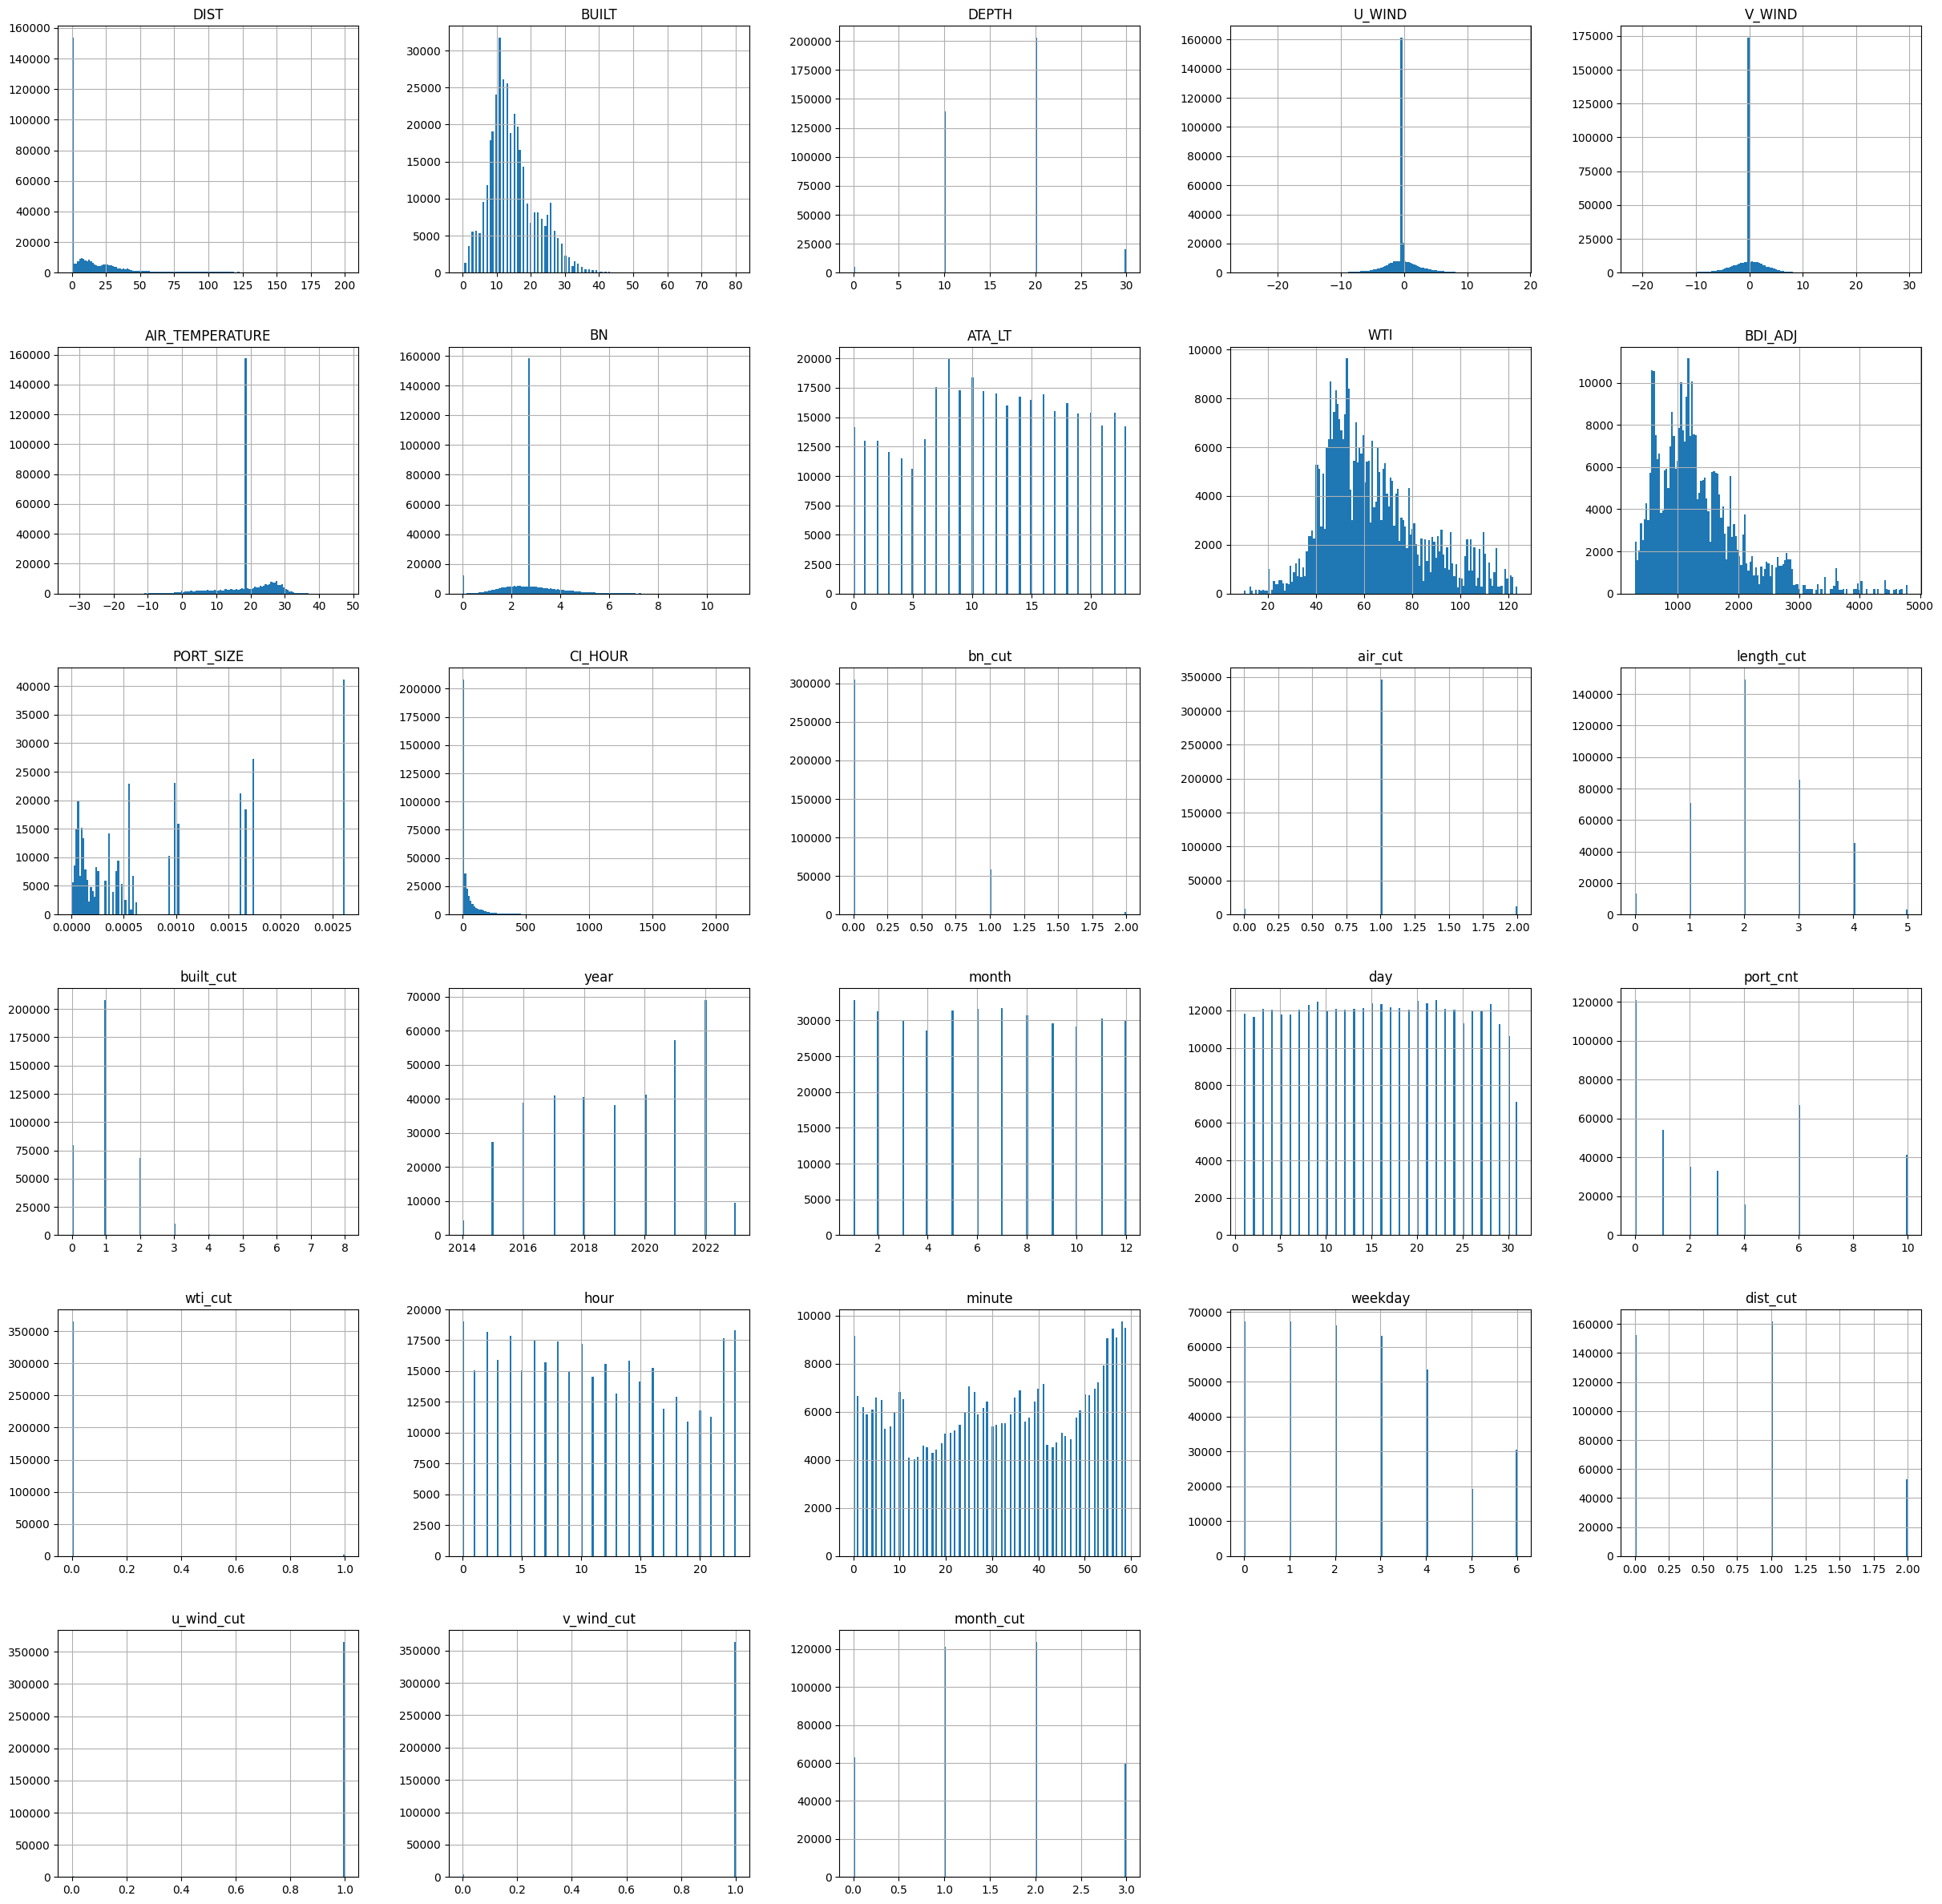

In [96]:
train.hist(figsize=(30,30),bins = 150)


In [ ]:
import seaborn as sns
df_corr = train.corr()
top_corr_features = df_corr.index[abs(df_corr["CI_HOUR"])>=0.1]
top_corr_features
plt.figure(figsize=(13,10))
tp = sns.heatmap(train[top_corr_features].corr(),vmin=-1,vmax=1,linewidths=0.2,annot=True,fmt='f',cmap="RdYlGn")
plt.show()

In [ ]:
plt.figure(figsize=(13,10))
tp = sns.heatmap(train.corr(),vmin=-1,vmax=1,linewidths=0.2,fmt='f',cmap="Blues")
plt.show()

In [ ]:
#DUBAI,BRENT,WTI 가 연관성이 깊으니 1개만 남기고 나머지 없앤다.
#LENGTH,GT,DRAUGHT,DEPTH,DEADWEIGHT,BREADTH가 연관성이 깊으니 1개만 남기고 나머지를 없앤다.
train = train.drop(columns=['BRENT','DUBAI','GT','DRAUGHT','DEADWEIGHT','BREADTH'])
test = test.drop(columns=['BRENT','DUBAI','GT','DRAUGHT','DEADWEIGHT','BREADTH'])

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: >]], dtype=object)

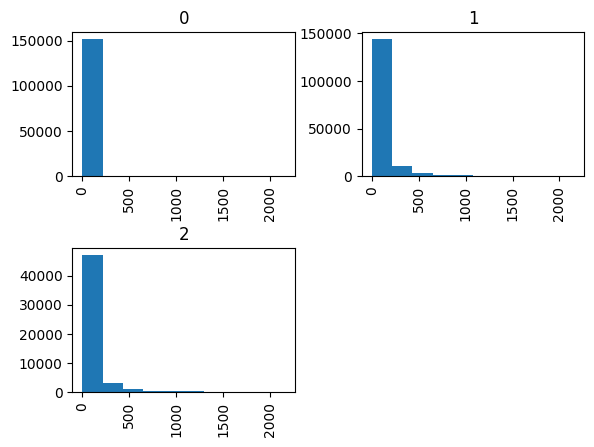

In [ ]:
train['dist_cut'] = 1
train.loc[train['DIST'] < 1,'dist_cut'] = 0
train.loc[train['DIST'] > 40,'dist_cut'] = 2
train.hist(column='CI_HOUR',by='dist_cut')



array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: title={'center': '4'}>,
        <Axes: title={'center': '5'}>],
       [<Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>,
        <Axes: title={'center': '8'}>]], dtype=object)

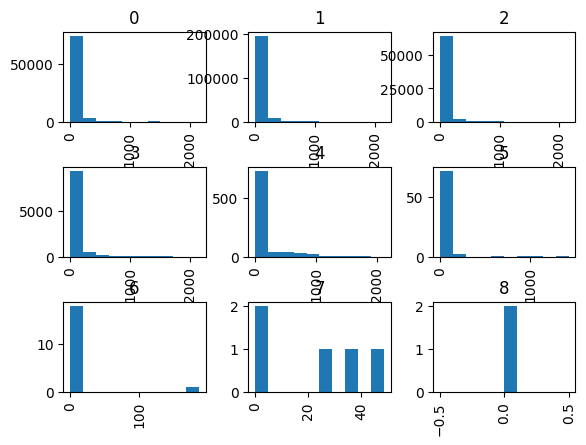

In [ ]:
def make_category(v):
  v = (v//10)
  return v

train.insert(25,'built_cut',train.BUILT.apply(make_category))
train.hist(column='CI_HOUR',by='built_cut')


array([[<Axes: title={'center': '0.0'}>, <Axes: title={'center': '1.0'}>],
       [<Axes: title={'center': '2.0'}>, <Axes: title={'center': '3.0'}>],
       [<Axes: title={'center': '4.0'}>, <Axes: title={'center': '5.0'}>]],
      dtype=object)

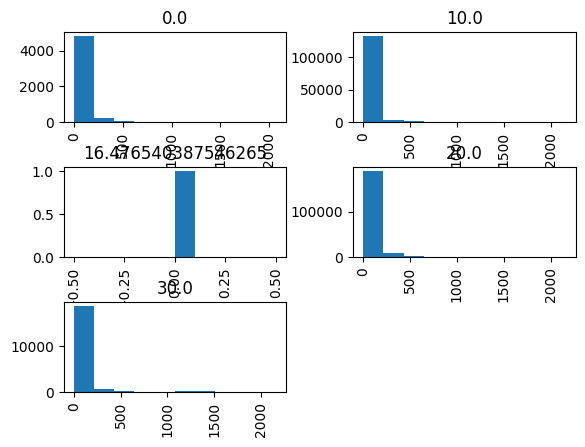

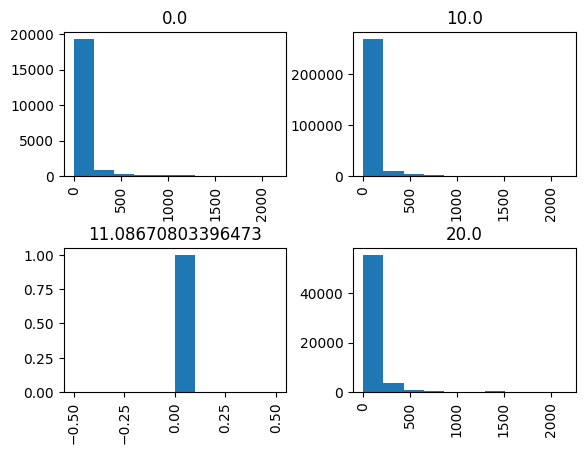

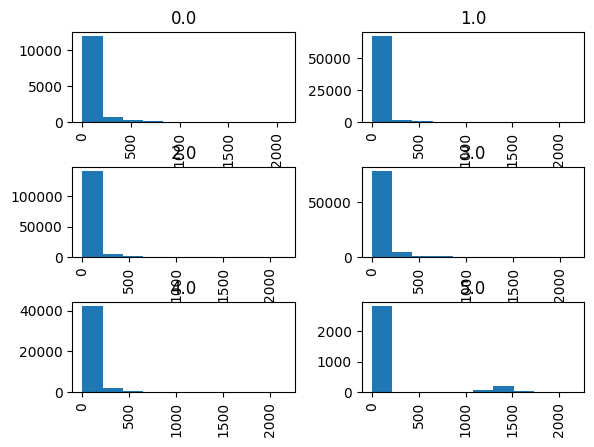

In [ ]:
def make_category2(v):
  v = (v//75)
  return v

train.insert(25,'length_cut',train.LENGTH.apply(make_category2))
train.hist(column='CI_HOUR',by='length_cut')

array([[<Axes: title={'center': 'CI_HOUR'}>]], dtype=object)

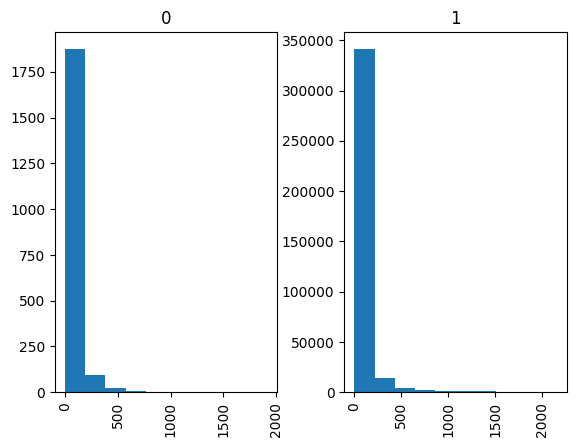

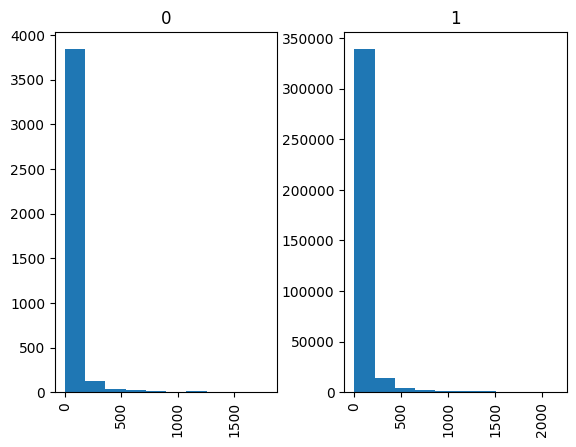

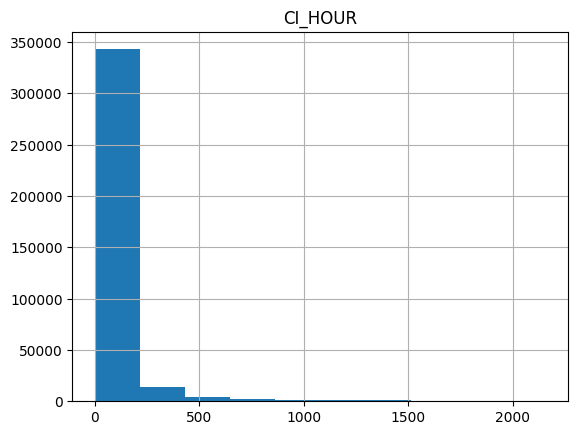

In [ ]:
train['u_wind_cut'] = 0
train['v_wind_cut'] = 0
train.loc[abs(train['U_WIND']) < 10,'u_wind_cut'] = 1
train.loc[abs(train['V_WIND']) < 10,'v_wind_cut'] = 1
train.hist(column='CI_HOUR',by='u_wind_cut')
train.hist(column='CI_HOUR',by='v_wind_cut')
train.hist(column='CI_HOUR')

#결측치가 많은 행이라 아예 열을 제거해도 괜찮을 수 있겠다.

dist_cut
0    [[Axes(0.1,0.6;0.347826x0.3), Axes(0.552174,0....
1    [[Axes(0.1,0.6;0.347826x0.3), Axes(0.552174,0....
2    [[Axes(0.1,0.6;0.347826x0.3), Axes(0.552174,0....
dtype: object

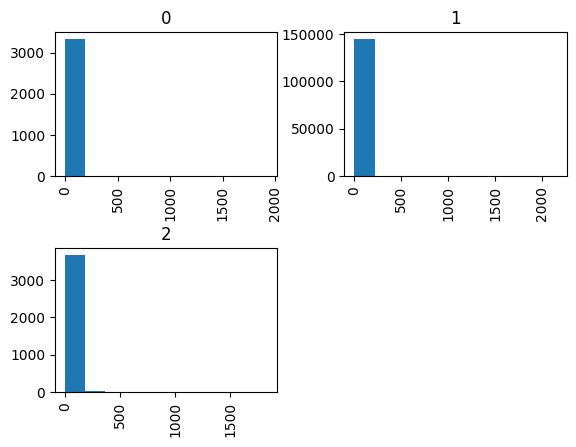

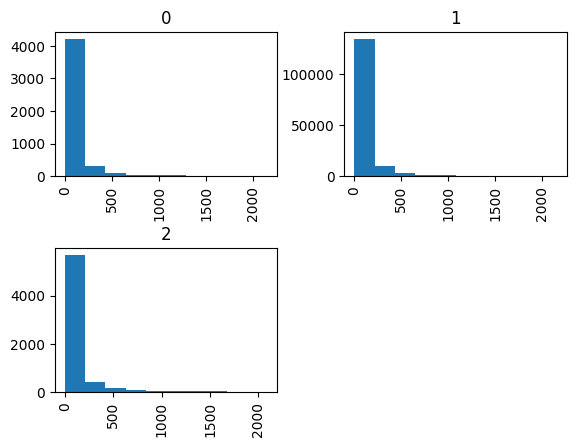

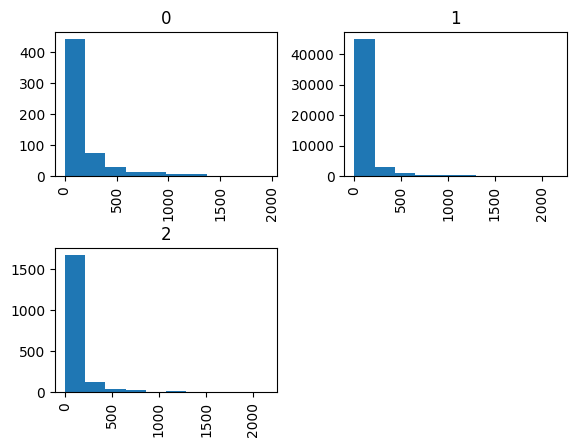

In [ ]:
train['air_cut'] = 1
train.loc[train['AIR_TEMPERATURE'] < 0,'air_cut'] = 0
train.loc[abs(train['AIR_TEMPERATURE']) > 30,'air_cut'] = 2
train.groupby(['dist_cut']).hist(column='CI_HOUR',by='air_cut')

dist_cut
0    [[Axes(0.1,0.6;0.347826x0.3), Axes(0.552174,0....
1    [[Axes(0.1,0.6;0.347826x0.3), Axes(0.552174,0....
2    [[Axes(0.1,0.6;0.347826x0.3), Axes(0.552174,0....
dtype: object

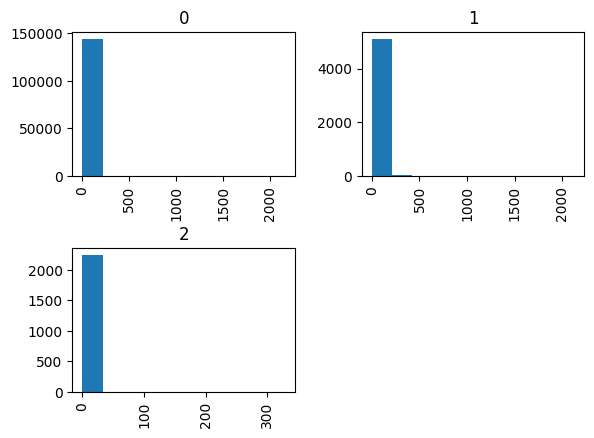

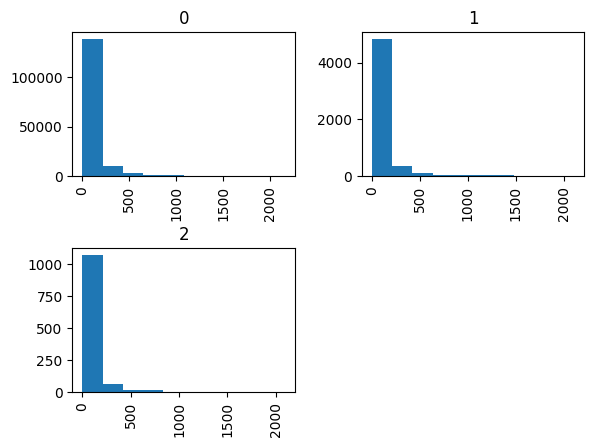

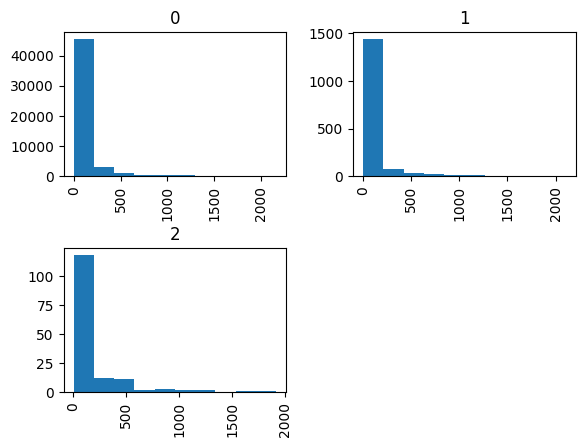

In [ ]:
train['bn_cut'] = 0
train.loc[train['BN'] <0.1,'bn_cut'] = 1
train.loc[train['BN'] > 6,'bn_cut'] = 2
train.groupby(['dist_cut']).hist(column='CI_HOUR',by='bn_cut')

dist_cut
0    [[Axes(0.1,0.792857;0.129032x0.107143), Axes(0...
1    [[Axes(0.1,0.792857;0.129032x0.107143), Axes(0...
2    [[Axes(0.1,0.792857;0.129032x0.107143), Axes(0...
dtype: object

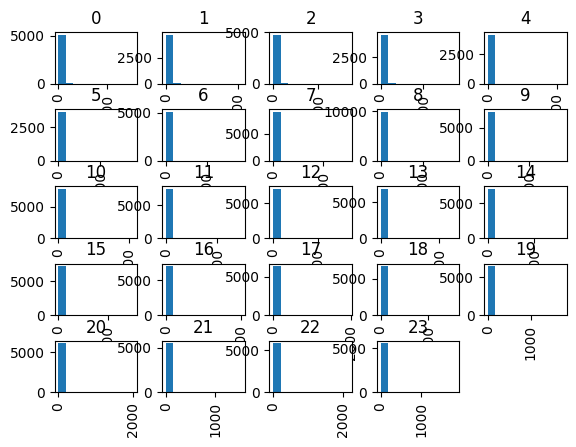

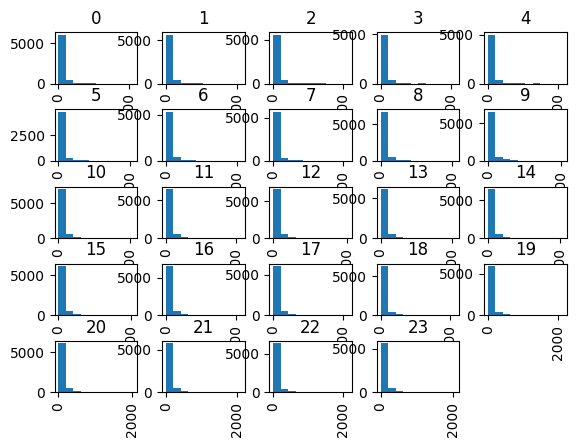

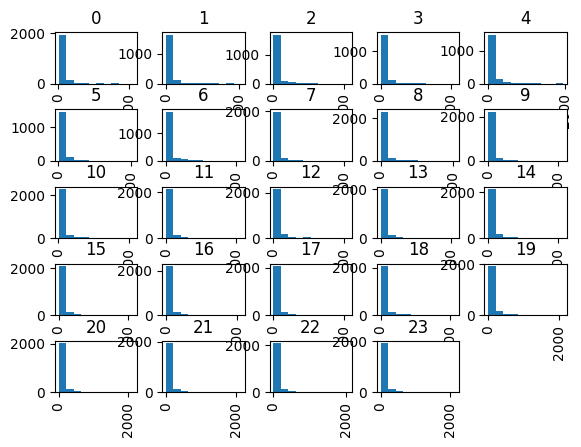

In [ ]:
train.groupby(['dist_cut']).hist(column='CI_HOUR',by='ATA_LT')

In [ ]:
train.insert(25,'wti_cut',train.WTI.apply(make_category(cnt=10)))
train.hist(column='CI_HOUR',by='wti_cut')


train.insert(25,'wti_cut',train.WTI.apply(make_category(cnt=10)))
train.hist(column='CI_HOUR',by='wti_cut')


In [ ]:
# 분포를 보면 WTI -40 인 데이터가 존재해 삭제하자.
idx = train[train['WTI']<=0].index
train.drop(idx,inplace=True)

In [ ]:
train = train.astype({'DEPTH':'int'})
test = test.astype({'DEPTH':'int'})
# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY','ID','SHIPMANAGER','FLAG','year','weekday','month','hour', 'DEPTH']
encoders = {}

for i in enumerate (categorical_features) :
    ca = i[1]
    train[ca] = train[ca].astype('category')
    test[ca] = test[ca].astype('category')

#for feature in tqdm(categorical_features, desc="Encoding features"):
#    le = LabelEncoder()
#    train[feature] = le.fit_transform(train[feature].astype(str))
#    le_classes_set = set(le.classes_)
#    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
#    le_classes = le.classes_.tolist()
#    bisect.insort_left(le_classes, '-1')
#    le.classes_ = np.array(le_classes)
#    test[feature] = le.transform(test[feature].astype(str))
#    encoders[feature] = le


## 모델 학습 및 특성 중요도 확인

In [ ]:
!pip install catboost

In [ ]:
import catboost
from scipy.stats import randint
from sklearn.utils.fixes import loguniform


def train_and_evaluate(model, X_train, y_train):
    model.randomized_search(param_grid,X_train,y_train,cv=3,n_iter=10)
    model.fit(X_train, y_train, cat_features=categorical_features)

    return model

param_grid = {
    'n_estimators': randint(100, 300),
    'depth': randint(1, 5),
    'learning_rate': loguniform(1e-3, 0.1),
    'min_child_samples': randint(10, 40),
    'grow_policy': ['SymmetricTree', 'Lossguide', 'Depthwise']
}

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
cat_model = train_and_evaluate(catboost.CatBoostRegressor(eval_metric='R2',cat_features=categorical_features), X_train, y_train)

0:	learn: -0.1087099	test: -0.1088791	best: -0.1088791 (0)	total: 271ms	remaining: 1m 15s
1:	learn: -0.0837698	test: -0.0836046	best: -0.0836046 (1)	total: 432ms	remaining: 59.9s
2:	learn: -0.0609630	test: -0.0611005	best: -0.0611005 (2)	total: 603ms	remaining: 55.5s
3:	learn: -0.0415536	test: -0.0412423	best: -0.0412423 (3)	total: 737ms	remaining: 50.6s
4:	learn: -0.0238025	test: -0.0233850	best: -0.0233850 (4)	total: 911ms	remaining: 49.9s
5:	learn: -0.0081921	test: -0.0079807	best: -0.0079807 (5)	total: 1.06s	remaining: 48.4s
6:	learn: 0.0061825	test: 0.0061986	best: 0.0061986 (6)	total: 1.21s	remaining: 47s
7:	learn: 0.0185396	test: 0.0181775	best: 0.0181775 (7)	total: 1.33s	remaining: 45s
8:	learn: 0.0288447	test: 0.0290361	best: 0.0290361 (8)	total: 1.46s	remaining: 43.9s
9:	learn: 0.0390644	test: 0.0391389	best: 0.0391389 (9)	total: 1.62s	remaining: 43.6s
10:	learn: 0.0480459	test: 0.0484991	best: 0.0484991 (10)	total: 1.78s	remaining: 43.3s
11:	learn: 0.0558813	test: 0.0566799	

## 특성 중요도로부터 Feature Selection

In [ ]:
cat = cat_model

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train), total=5, desc="Processing folds"):
    X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    cat.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = cat.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    cat_pred = cat.predict(test)
    cat_pred = np.where(cat_pred < 0, 0, cat_pred)

    ensemble_predictions.append(cat_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.0138408	total: 215ms	remaining: 55.7s
1:	learn: 0.0261286	total: 341ms	remaining: 43.9s
2:	learn: 0.0366668	total: 522ms	remaining: 44.7s
3:	learn: 0.0464647	total: 656ms	remaining: 42s
4:	learn: 0.0547677	total: 803ms	remaining: 41s
5:	learn: 0.0627302	total: 996ms	remaining: 42.2s
6:	learn: 0.0703131	total: 1.19s	remaining: 43.1s
7:	learn: 0.0760653	total: 1.37s	remaining: 43.1s
8:	learn: 0.0820879	total: 1.53s	remaining: 42.8s
9:	learn: 0.0877821	total: 1.7s	remaining: 42.6s
10:	learn: 0.0925179	total: 1.82s	remaining: 41.2s
11:	learn: 0.0964372	total: 1.97s	remaining: 40.6s
12:	learn: 0.1013149	total: 2.19s	remaining: 41.6s
13:	learn: 0.1054791	total: 2.35s	remaining: 41.2s
14:	learn: 0.1099390	total: 2.56s	remaining: 41.8s
15:	learn: 0.1143369	total: 2.74s	remaining: 41.8s
16:	learn: 0.1180803	total: 2.95s	remaining: 42.1s
17:	learn: 0.1213828	total: 3.14s	remaining: 42.2s
18:	learn: 0.1254168	total: 3.36s	remaining: 42.6s
19:	learn: 0.1285339	total: 3.55s	remaining: 4

Processing folds:  20%|██        | 1/5 [00:54<03:37, 54.32s/it]

0:	learn: 0.0136793	total: 191ms	remaining: 49.4s
1:	learn: 0.0257216	total: 284ms	remaining: 36.7s
2:	learn: 0.0358542	total: 464ms	remaining: 39.8s
3:	learn: 0.0453687	total: 624ms	remaining: 40s
4:	learn: 0.0548371	total: 808ms	remaining: 41.2s
5:	learn: 0.0620173	total: 953ms	remaining: 40.3s
6:	learn: 0.0687690	total: 1.04s	remaining: 37.6s
7:	learn: 0.0744275	total: 1.24s	remaining: 39s
8:	learn: 0.0808709	total: 1.36s	remaining: 38s
9:	learn: 0.0868481	total: 1.57s	remaining: 39.3s
10:	learn: 0.0925754	total: 1.77s	remaining: 40.1s
11:	learn: 0.0980111	total: 1.93s	remaining: 39.9s
12:	learn: 0.1018961	total: 2.07s	remaining: 39.3s
13:	learn: 0.1056937	total: 2.22s	remaining: 39s
14:	learn: 0.1087198	total: 2.38s	remaining: 38.9s
15:	learn: 0.1127377	total: 2.58s	remaining: 39.3s
16:	learn: 0.1164435	total: 2.76s	remaining: 39.5s
17:	learn: 0.1194316	total: 2.95s	remaining: 39.6s
18:	learn: 0.1226515	total: 3.15s	remaining: 39.9s
19:	learn: 0.1252402	total: 3.32s	remaining: 39.9

Processing folds:  40%|████      | 2/5 [01:49<02:44, 54.94s/it]

0:	learn: 0.0130756	total: 204ms	remaining: 53s
1:	learn: 0.0256774	total: 365ms	remaining: 47.1s
2:	learn: 0.0367997	total: 455ms	remaining: 39s
3:	learn: 0.0462871	total: 656ms	remaining: 42s
4:	learn: 0.0544989	total: 862ms	remaining: 44s
5:	learn: 0.0623713	total: 1.03s	remaining: 43.5s
6:	learn: 0.0688923	total: 1.15s	remaining: 41.4s
7:	learn: 0.0762731	total: 1.29s	remaining: 40.6s
8:	learn: 0.0823401	total: 1.45s	remaining: 40.4s
9:	learn: 0.0879693	total: 1.63s	remaining: 40.7s
10:	learn: 0.0935484	total: 1.77s	remaining: 40.2s
11:	learn: 0.0982608	total: 1.94s	remaining: 40.1s
12:	learn: 0.1017872	total: 2.09s	remaining: 39.8s
13:	learn: 0.1063601	total: 2.26s	remaining: 39.8s
14:	learn: 0.1106950	total: 2.48s	remaining: 40.4s
15:	learn: 0.1134200	total: 2.62s	remaining: 39.9s
16:	learn: 0.1170182	total: 2.83s	remaining: 40.5s
17:	learn: 0.1205535	total: 3.02s	remaining: 40.7s
18:	learn: 0.1246813	total: 3.22s	remaining: 40.9s
19:	learn: 0.1277140	total: 3.42s	remaining: 41s


Processing folds:  60%|██████    | 3/5 [02:44<01:50, 55.10s/it]

0:	learn: 0.0135597	total: 200ms	remaining: 51.7s
1:	learn: 0.0257251	total: 316ms	remaining: 40.7s
2:	learn: 0.0362289	total: 500ms	remaining: 42.8s
3:	learn: 0.0450128	total: 627ms	remaining: 40.1s
4:	learn: 0.0535465	total: 776ms	remaining: 39.6s
5:	learn: 0.0610889	total: 951ms	remaining: 40.3s
6:	learn: 0.0675681	total: 1.1s	remaining: 40s
7:	learn: 0.0748522	total: 1.25s	remaining: 39.3s
8:	learn: 0.0798646	total: 1.33s	remaining: 37.1s
9:	learn: 0.0848451	total: 1.51s	remaining: 37.7s
10:	learn: 0.0907756	total: 1.63s	remaining: 36.9s
11:	learn: 0.0962733	total: 1.8s	remaining: 37.3s
12:	learn: 0.0995894	total: 1.94s	remaining: 36.9s
13:	learn: 0.1033754	total: 2.08s	remaining: 36.6s
14:	learn: 0.1066392	total: 2.24s	remaining: 36.6s
15:	learn: 0.1106338	total: 2.45s	remaining: 37.4s
16:	learn: 0.1141685	total: 2.66s	remaining: 38s
17:	learn: 0.1178043	total: 2.89s	remaining: 38.9s
18:	learn: 0.1197957	total: 3.06s	remaining: 38.8s
19:	learn: 0.1228733	total: 3.27s	remaining: 39

Processing folds:  80%|████████  | 4/5 [03:37<00:54, 54.12s/it]

0:	learn: 0.0129944	total: 303ms	remaining: 1m 18s
1:	learn: 0.0253128	total: 467ms	remaining: 1m
2:	learn: 0.0361633	total: 593ms	remaining: 50.8s
3:	learn: 0.0458586	total: 751ms	remaining: 48.1s
4:	learn: 0.0544495	total: 951ms	remaining: 48.5s
5:	learn: 0.0618784	total: 1.14s	remaining: 48.1s
6:	learn: 0.0692726	total: 1.29s	remaining: 46.7s
7:	learn: 0.0752609	total: 1.47s	remaining: 46.4s
8:	learn: 0.0806411	total: 1.65s	remaining: 45.9s
9:	learn: 0.0876000	total: 1.81s	remaining: 45.4s
10:	learn: 0.0922577	total: 1.94s	remaining: 44s
11:	learn: 0.0982377	total: 2.1s	remaining: 43.4s
12:	learn: 0.1018406	total: 2.24s	remaining: 42.6s
13:	learn: 0.1051873	total: 2.42s	remaining: 42.5s
14:	learn: 0.1097204	total: 2.62s	remaining: 42.8s
15:	learn: 0.1129101	total: 2.81s	remaining: 42.9s
16:	learn: 0.1170211	total: 3s	remaining: 42.9s
17:	learn: 0.1201327	total: 3.19s	remaining: 42.9s
18:	learn: 0.1243070	total: 3.38s	remaining: 42.9s
19:	learn: 0.1270900	total: 3.57s	remaining: 42.9

Processing folds: 100%|██████████| 5/5 [04:29<00:00, 53.95s/it]

Validation : MAE scores for each fold: [59.503182758753255, 60.67485825831127, 61.56183473411397, 60.525394954017415, 60.107331791247915]
Validation : MAE: 60.47452049928877


## Submission

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/hd/sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('./baseline_submit.csv', index=False)